# Recovery of gold from ore

Create a prototype machine learning model for a company that develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery factor for gold from gold ore. Use data with mining and cleaning parameters.

The model should help optimize production to avoid creating a company with unprofitable properties.

We need:

1. prepare data;
2. perform an exploratory data analysis;
3. create and train the model.

## Technological process description

During the initial processing of the mined ore, a crushed mixture is obtained. It is fed to flotation (enrichment) and two-stage purification.

Description of each stage:
1. flotation
A mixture of gold-bearing ores is fed into the flotation plant. After enrichment, a coarse concentrate and "dump tails" are obtained, i.e. product residues with a low concentration of valuable metals.
The stability of this process is affected by the unstable and non-optimal physicochemical state of the flotation slurry (a mixture of solid particles and liquid).
2. purification
The raw concentrate passes through two purification stages. The result is the final concentrate and new final waste.
Data description

**Technological process**

	* Rougher feed — initial raw material 
	* Rougher additions (или reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
	* Xanthate **— xanthate (promoter, or flotation activator);
	* Sulphate — sulfate (in this production, sodium sulfide);
	* Depressant — depressant (sodium silicate).
	* Rougher process — flotation
	* Rougher tails — dump tailings
	* Float banks — flotation plant
	* Cleaner process — purification
	* Rougher Au — crude gold concentrate
	* Final Au — final gold concentrate

**Stage parameters**

	* air amount 
	* fluid levels
	* feed size — raw material granule size
	* feed rate

**Names of features**

The name of the features should be:
[stage].[parameter_type].[parameter_name]

Example: rougher.input.feed_ag

Possible values for the block[stage]:

	* rougher — flotation
	* primary_cleaner — primary cleaning
	* secondary_cleaner — secondary cleaning
	* final — final characteristics
Possible values for the block [parameter_type]:

	* input — raw material parameters
	* output — product parameters
	* state — parameters characterizing the current state of the stage
	* calculation — design characteristics
**Efficiency calculation**

It is necessary to simulate the process of extracting gold from gold ore.
The enrichment efficiency is calculated according to the following formula:

$$Recovery=\frac{C\times(F-T)}{F\times(C-T)}\times100\%$$

where:

$C$ — percentage of gold in concentrate after flotation/refining;

$F$ — share of gold in raw material/concentrate before flotation/refining;

$T$ — proportion of gold in waste tailings after flotation/cleaning.

To predict the ratio, you need to determine the gold content in concentrates and tailings. Moreover, not only the final product is important, but also the rough concentrate.

**Quality metric**

To solve the problem, we introduce the quality metric — sMAPE (англ. Symmetric Mean Absolute Percentage Error).
It is similar to MAE, but is expressed not in absolute terms, but in relative terms. Why is it symmetrical? It equally takes into account the scale of both the target feature and the prediction.

The sMAPE metric is calculated as follows:

$$sMAPE=\frac{1}{N}\sum_{i=1}^{N}\frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2}\times100\%$$

Notation:


$y_i$ -	The value of the target feature for the object with serial number i in the sample on which the quality is measured.

$\hat{y_i}$	- Prediction value for the object with index i, for example, in the test sample.

$N$ - Number of objects in the sample.


You need to predict two quantities at once:
* crude concentrate enrichment efficiency rougher.output.recovery;
* final concentrate enrichment efficiency final.output.recovery.

The final metric is made up of two values:

$$finalSMAPE=25\%\times{sMAPE_{rougher}}+75\%\times{sMAPE_{final}}$$

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from scipy import stats

## Data preparation

Let's load the records and familiarize ourselves with their contents:

In [2]:
df_0 = pd.read_csv('/content/gold_recovery_train_new.csv')
df_1 = pd.read_csv('/content/gold_recovery_test_new.csv')
df_2 = pd.read_csv('/content/gold_recovery_full_new.csv')

In [3]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
df_0.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [6]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


There are gaps in the data. The column "date" is in object format, we need to convert the data and fill in the missing values

In [7]:
df_0['date'] = pd.to_datetime(df_0['date'], format='%Y-%m-%d %H:%M:%S')

In [8]:
df_1['date'] = pd.to_datetime(df_1['date'], format='%Y-%m-%d %H:%M:%S')

In [9]:
df_2['date'] = pd.to_datetime(df_2['date'], format='%Y-%m-%d %H:%M:%S')

### Filling gaps in data

The largest number of gaps in the training dataset in the secondary_cleaner.output.tail_sol column:

In [10]:
df_0.isna().mean().sort_values(ascending=False).head(15)

secondary_cleaner.output.tail_sol           0.113436
rougher.state.floatbank10_e_air             0.030815
rougher.input.floatbank11_xanthate          0.030249
primary_cleaner.output.concentrate_sol      0.020213
secondary_cleaner.state.floatbank2_a_air    0.015337
final.output.concentrate_sol                0.014913
rougher.input.feed_size                     0.010177
primary_cleaner.input.xanthate              0.007068
rougher.input.feed_pb                       0.007068
final.output.tail_pb                        0.007068
primary_cleaner.output.concentrate_pb       0.006078
rougher.input.feed_sol                      0.005513
primary_cleaner.output.tail_sol             0.003251
rougher.input.floatbank11_sulfate           0.002544
primary_cleaner.input.depressant            0.002262
dtype: float64

The data are indexed in time. Depending on the technical method, the parameters change evenly over time, so you can fill the gaps in the data using the interpolation method.

In [11]:
df_0 = df_0.set_index('date')

In [12]:
df_0_filled = df_0.interpolate(method='time')

In [13]:
df_1 = df_1.set_index('date')

In [14]:
df_1_filled = df_1.interpolate(method='time')

In [15]:
df_2 = df_2.set_index('date')

In [16]:
df_2_filled = df_2.interpolate(method='time')

Let's check if the filled-in values led to significant distortions in the distributions of the parameter values that have the largest number of gaps:

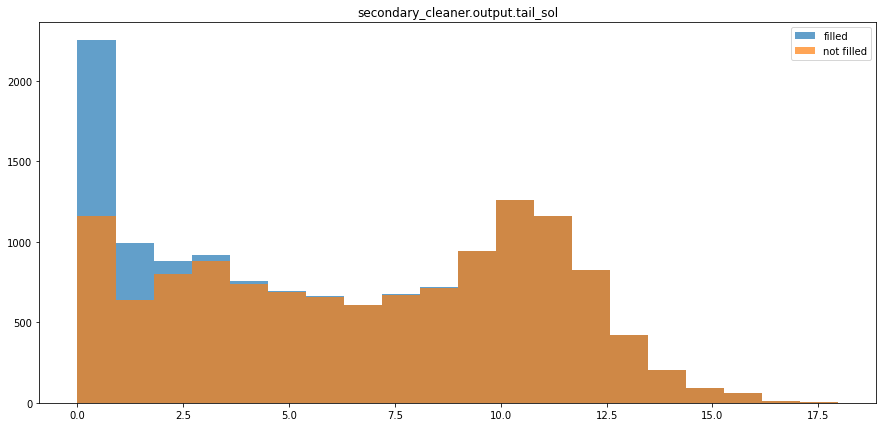

In [17]:
plt.figure(figsize=(15,7))
plt.title('secondary_cleaner.output.tail_sol')
plt.hist(df_0_filled['secondary_cleaner.output.tail_sol'], alpha=0.7, bins=20, label='filled')
plt.hist(df_0['secondary_cleaner.output.tail_sol'], alpha=0.7, bins=20, label='not filled')
plt.legend()
plt.show()

There are many gaps in the secondary_cleaner.output.tail_sol column in a row, it is not possible to fill them appropriately without moving the distribution of the parameter. This parameter is an output and is not used for training models.

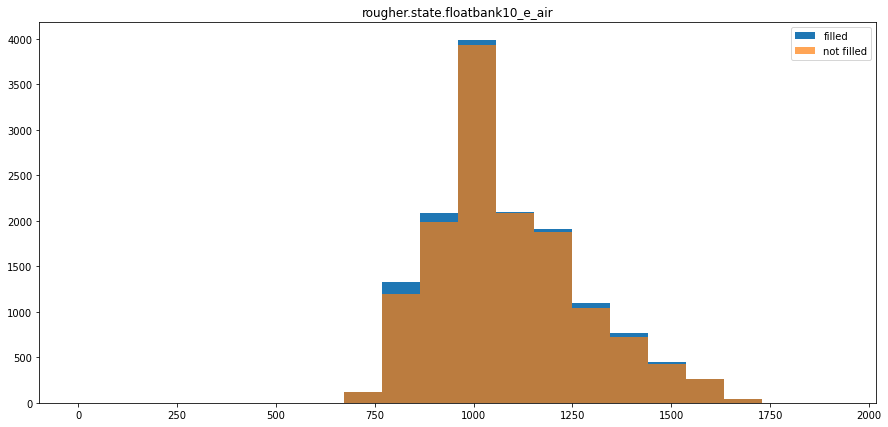

In [18]:
plt.figure(figsize=(15,7))
plt.title('rougher.state.floatbank10_e_air')
plt.hist(df_0_filled['rougher.state.floatbank10_e_air'], bins=20, label='filled')
plt.hist(df_0['rougher.state.floatbank10_e_air'], alpha=.7, bins=20, label='not filled')
plt.legend()
plt.show()

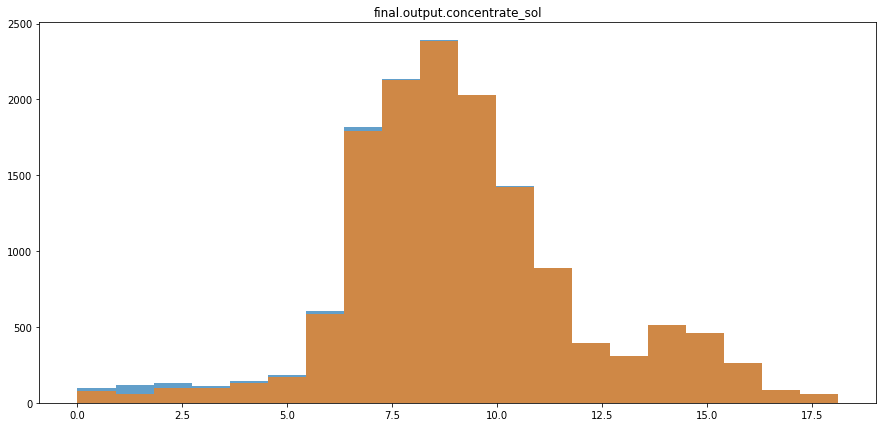

In [19]:
plt.figure(figsize=(15,7))
plt.title('final.output.concentrate_sol')
plt.hist(df_0_filled['final.output.concentrate_sol'], alpha=.7, bins=20)
plt.hist(df_0['final.output.concentrate_sol'], alpha=.7, bins=20)
plt.show()

### Analysis of characteristics that are not present in the test sample

Columns that are not available in the sample contain the final and calculated parameters that will become available at later stages of the engineering process, and therefore cannot be used as features to build models.

In [20]:
sorted(list(set(df_0.columns) - set(df_1.columns)))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

### Verification of the correctness of the calculation of the processing efficiency

Calculate the efficiency of ore processing according to the formula from the task:

In [21]:
df_0_filled['rougher.calculation.recovery_au'] = ((df_0_filled['rougher.output.concentrate_au'] * \
(df_0_filled['rougher.input.feed_au'] - df_0_filled['rougher.output.tail_au'])) / \
(df_0_filled['rougher.input.feed_au'] * \
(df_0_filled['rougher.output.concentrate_au'] - df_0_filled['rougher.output.tail_au'])) * 100)

Let's compare the average values of the calculated and available processing efficiencies:

In [22]:
df_0_filled['rougher.calculation.recovery_au'].mean()

82.70450164550293

In [23]:
df_0_filled['rougher.output.recovery'].mean()

82.70450164550293

In [24]:
mean_absolute_error(df_0_filled['rougher.output.recovery'], \
                    df_0_filled['rougher.calculation.recovery_au'])

9.73512347450521e-15

MAE between the calculated and the available values of rougher.output.recovery tends to zero, the average values in the columns are the same.

## Data analysis

Find the names of the columns that contain data on the output concentrations of the metals:

In [25]:
df_0_filled.filter(regex='output.concentrate', axis="columns").columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au'],
      dtype='object')

### Analysis of the change in the concentration of metals in different purification stages

Let's analyze the concentrations at different stages by visually evaluating the distributions of their values

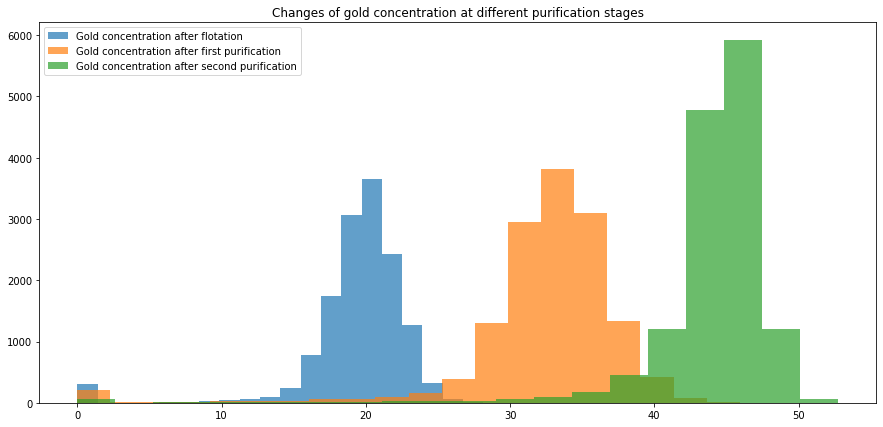

In [26]:
bins=20
plt.figure(figsize=(15,7))
plt.title('Changes of gold concentration at different purification stages')
plt.hist(df_0_filled['rougher.output.concentrate_au'], 
         bins=bins, alpha=0.7, label='Gold concentration after flotation')
plt.hist(df_0_filled['primary_cleaner.output.concentrate_au'], 
         bins=bins, alpha=0.7, label='Gold concentration after first purification')
plt.hist(df_0_filled['final.output.concentrate_au'], 
         bins=bins, alpha=0.7, label='Gold concentration after second purification')
plt.legend(loc='upper left')
plt.show()

In [27]:
df_0_filled['rougher.output.concentrate_au'].mean()

19.43995785143646

In [28]:
df_0_filled['primary_cleaner.output.concentrate_au'].mean()

32.386835978391346

In [29]:
df_0_filled['final.output.concentrate_au'].mean()

44.00379162105571

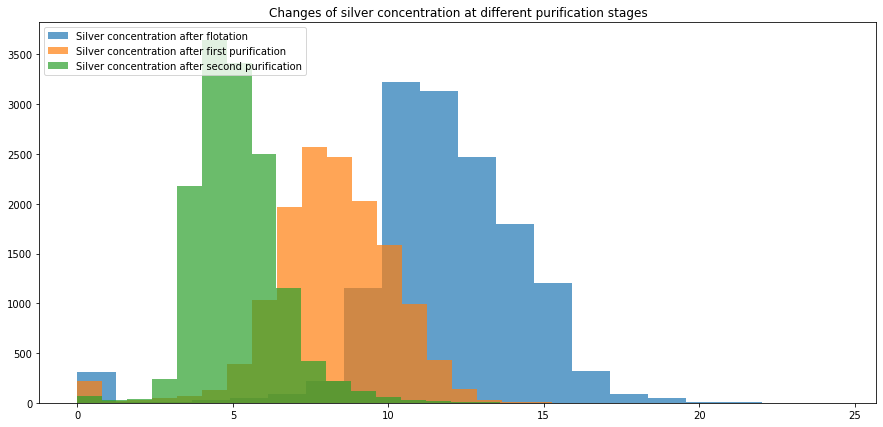

In [30]:
bins=20
plt.figure(figsize=(15,7))
plt.title('Changes of silver concentration at different purification stages')
plt.hist(df_0_filled['rougher.output.concentrate_ag'], 
         bins=bins, alpha=0.7, label='Silver concentration after flotation')
plt.hist(df_0_filled['primary_cleaner.output.concentrate_ag'], 
         bins=bins, alpha=0.7, label='Silver concentration after first purification')
plt.hist(df_0_filled['final.output.concentrate_ag'], 
         bins=bins, alpha=0.7, label='Silver concentration after second purification')
plt.legend(loc='upper left')
plt.show()

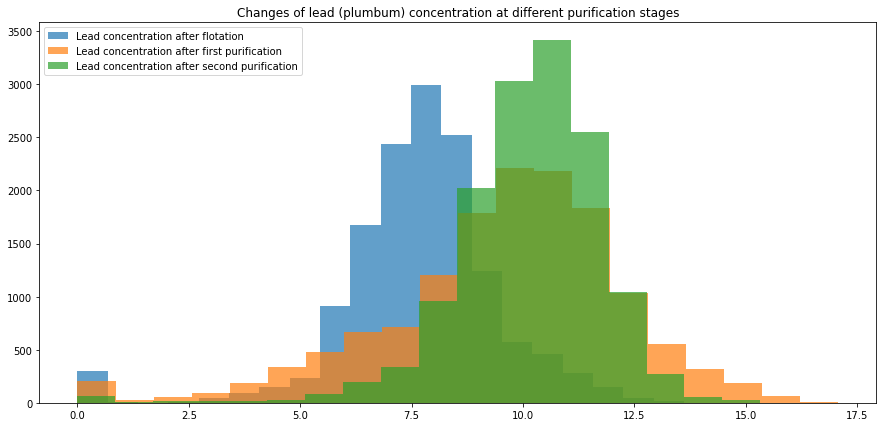

In [31]:
bins=20
plt.figure(figsize=(15,7))
plt.title('Changes of lead (plumbum) concentration at different purification stages')
plt.hist(df_0_filled['rougher.output.concentrate_pb'], 
         bins=bins, alpha=0.7, label='Lead concentration after flotation')
plt.hist(df_0_filled['primary_cleaner.output.concentrate_pb'], 
         bins=bins, alpha=0.7, label='Lead concentration after first purification')
plt.hist(df_0_filled['final.output.concentrate_pb'], 
         bins=bins, alpha=0.7, label='Lead concentration after second purification')
plt.legend(loc='upper left')
plt.show()

The gold concentration increases significantly with the processing stages, the concentrations of the impurities change much less.

### Comparison of granule sizes of raw materials in samples

Let's compare the sizes of raw material granules in the train and test samples

In [32]:
df_0_filled.filter(regex='feed_size', axis="columns").columns

Index(['primary_cleaner.input.feed_size', 'rougher.input.feed_size'], dtype='object')

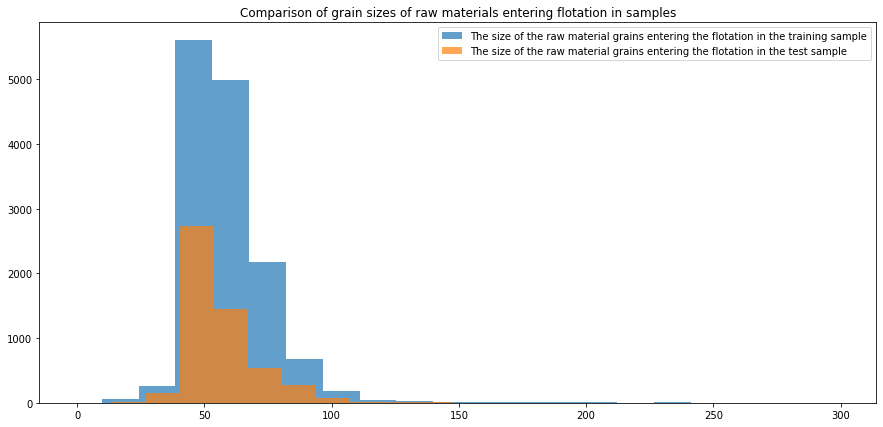

In [33]:
bins=20
plt.figure(figsize=(15,7))
plt.title('Comparison of grain sizes of raw materials entering flotation in samples')
plt.hist(df_0_filled[df_0_filled['rougher.input.feed_size'] < 300]['rougher.input.feed_size'], 
         bins=bins, alpha=0.7, 
         label='The size of the raw material grains entering the flotation in the training sample')
plt.hist(df_1_filled[df_1_filled['rougher.input.feed_size'] < 300]['rougher.input.feed_size'], 
         bins=bins, alpha=0.7, 
         label='The size of the raw material grains entering the flotation in the test sample')
plt.legend(loc='upper right')
plt.show()

In [34]:
df_0_filled['rougher.input.feed_size'].mean()

60.033540906765616

In [35]:
df_1_filled['rougher.input.feed_size'].mean()

55.95283531239522

In [36]:
df_0_filled['rougher.input.feed_size'].mean() / df_1_filled['rougher.input.feed_size'].mean()

1.0729311673231043

The average size of grains entering the first stage of production differs by 7.29% among the samples.

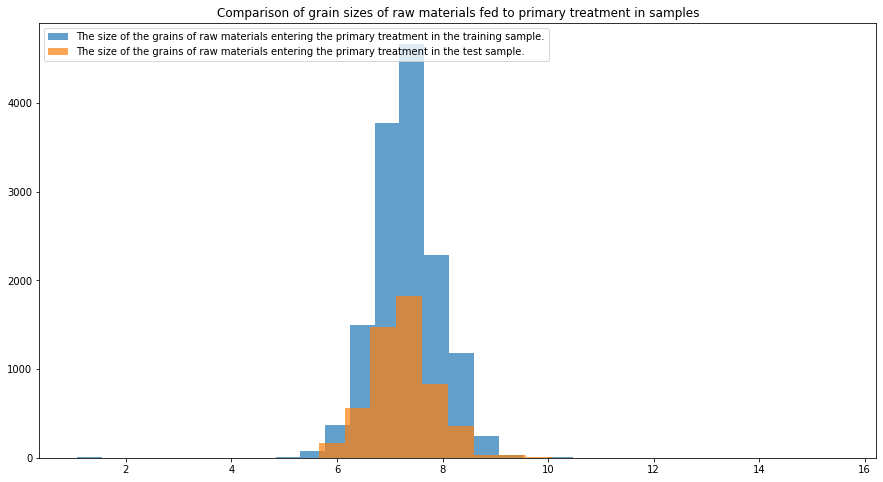

In [37]:
bins=20
plt.figure(figsize=(15,8))
plt.title('Comparison of grain sizes of raw materials fed to primary treatment in samples')
plt.hist(df_0_filled['primary_cleaner.input.feed_size'], 
         bins=bins, alpha=0.7, 
         label='The size of the grains of raw materials entering the primary treatment in the training sample.')
plt.hist(df_1_filled['primary_cleaner.input.feed_size'], 
         bins=bins, alpha=0.7, 
         label='The size of the grains of raw materials entering the primary treatment in the test sample.')
plt.legend(loc='upper left')
plt.show()

In [38]:
df_0_filled['primary_cleaner.input.feed_size'].mean()

7.322309906901314

In [39]:
df_1_filled['primary_cleaner.input.feed_size'].mean()

7.266339191270906

In [40]:
df_0_filled['primary_cleaner.input.feed_size'].mean(
) / df_1_filled['primary_cleaner.input.feed_size'].mean()

1.007702739186418

The average size of grains entering the second stage of production differs by 0.7% among the samples.

Since the task does not specify how large the allowable difference in the size of the grains in the samples may be, we consider it insignificant.

### Study of the total concentration of substances at different stages of processing

Let's determine the total concentrations of the substances and draw diagrams of their changes according to production stages

In [41]:
df_0_filled.filter(regex='concentrate', axis="columns").columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au'],
      dtype='object')

In [42]:
sum_au = df_0_filled[['rougher.output.concentrate_au', \
             'primary_cleaner.output.concentrate_au', \
             'final.output.concentrate_au']].sum()

In [43]:
sum_ag = df_0_filled[['rougher.output.concentrate_ag', \
             'primary_cleaner.output.concentrate_ag', \
             'final.output.concentrate_ag']].sum()

In [44]:
sum_pb = df_0_filled[['rougher.output.concentrate_pb', \
             'primary_cleaner.output.concentrate_pb', \
             'final.output.concentrate_pb']].sum()

In [45]:
sum_sol = df_0_filled[['rougher.output.concentrate_sol', \
             'primary_cleaner.output.concentrate_sol', \
             'final.output.concentrate_sol']].sum()

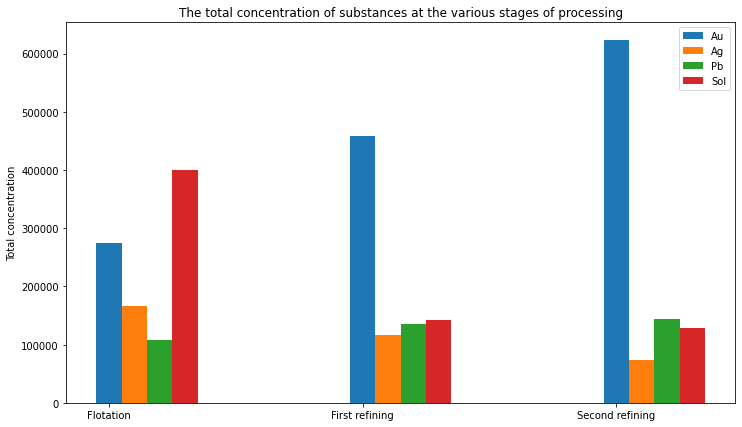

In [46]:
x = np.arange(len(sum_ag))
labels = ['Flotation', 'First refining', 'Second refining']
width = 0.1 
fig, ax = plt.subplots(figsize=(12,7))
rects1 = ax.bar(x, sum_au, width, label='Au')
rects2 = ax.bar(x + width, sum_ag, width, label='Ag')
rects3 = ax.bar(x + 2*width, sum_pb, width, label='Pb')
rects4 = ax.bar(x + 3*width, sum_sol, width, label='Sol')
ax.set_ylabel('Total concentration')
ax.set_title('The total concentration of substances at the various stages of processing')
ax.legend()
plt.xticks(x, labels)

plt.show()

In [47]:
df_2_filled['sum_input'] = df_2_filled[['rougher.input.feed_au', 'rougher.input.feed_ag', \
                         'rougher.input.feed_pb']].sum(axis=1)

In [48]:
df_2_filled['sum_rougher'] = df_2_filled[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', \
                           'rougher.output.concentrate_pb']].sum(axis=1)

In [49]:
df_2_filled['sum_primary'] = df_2_filled[['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', \
              'primary_cleaner.output.concentrate_pb']].sum(axis=1)

In [50]:
df_2_filled['sum_final'] = df_2_filled[['final.output.concentrate_au', 'final.output.concentrate_ag', \
             'final.output.concentrate_pb']].sum(axis=1)

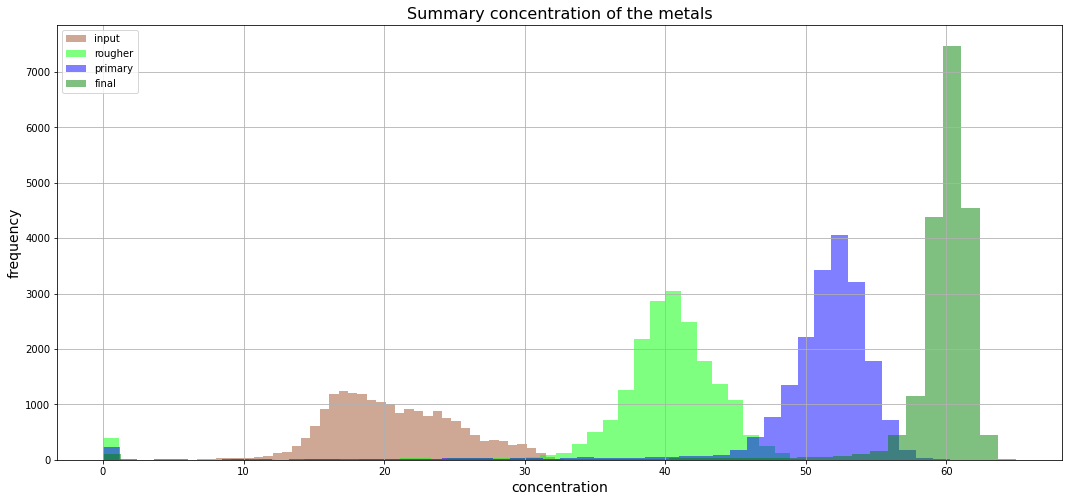

In [51]:
ALPHA = 0.5
BINS  = 50
COLORS = ['sienna', 'lime', 'blue', 'green']

fig, ax1 = plt.subplots(figsize=(18,8))
ax1.set_title('Summary concentration of the metals', fontsize=16)
plt.hist(df_2_filled['sum_input'], color='sienna', bins=BINS, alpha=ALPHA, label='input')
plt.hist(df_2_filled['sum_rougher'], color='lime', bins=BINS, alpha=ALPHA, label='rougher')
plt.hist(df_2_filled['sum_primary'], color='blue', bins=BINS, alpha=ALPHA, label='primary')
plt.hist(df_2_filled['sum_final'], color='green', bins=BINS, alpha=ALPHA, label='final')

plt.grid(True)
ax1.set_xlabel('concentration', fontsize=14)
ax1.set_ylabel('frequency', fontsize=14)
ax1.legend(loc='upper left')
plt.show()

The gold concentration increases categorically, which means that the process is effective. The content of Ag and Sol impurities decreases noticeably, while the Pb concentration increases slightly, possibly due to the peculiarities of the process.

## ML model

### sMAPE calculation function

The main task metric is the symmetric mean absolute deviation, which we will calculate using the following functions:

In [52]:
def smape(y_pred, y_true):
    """sMAPE calculation"""
    return 100/len(y_pred) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_pred) + np.abs(y_true)))

In [53]:
def final_smape(y_true_rougher, y_true_final, y_pred_rougher, y_pred_final):
    """Final sMAPE calculation"""
    return (.25 * smape(y_true_rougher, y_pred_rougher) + .75 * smape(y_true_final, y_pred_final))

### Preparing data for the models creation

#### rougher.output.recovery

To predict the rougher.output.recovery parameter, we will use the features that are available in the test dataset and correspond to a particular phase of the workflow.

In [54]:
rougher_columns = []
for col in df_0_filled.columns:
    if 'rougher.input' in col or 'rougher.state' in col or 'rougher.output.recovery' in col:
        rougher_columns.append(col)

In [55]:
rougher_train = df_0_filled[rougher_columns]

In [56]:
rougher_train.shape

(14149, 23)

Eliminate outliers in the data by discarding values that exceed three standard deviations

In [57]:
rougher_train_cut = rougher_train[(np.abs(stats.zscore(rougher_train)) < 3).all(axis=1)]

Split the data into features and target sets

In [58]:
rougher_train_features = rougher_train_cut.drop('rougher.output.recovery', axis=1)
rougher_train_target = rougher_train_cut['rougher.output.recovery']
[rougher_train_features.shape, rougher_train_target.shape]

[(12712, 22), (12712,)]

To check the model against test data, we need the values of the targets obtained from the full data set (df_2)

In [59]:
rougher_test_target = df_1_filled.index.map(df_2_filled['rougher.output.recovery'])

Not all columns in the test set are relevant to this process step. Filter out the ones we need.

In [60]:
rougher_test_features_columns = []
for col in df_0_filled.columns:
    if 'rougher.input' in col or 'rougher.state' in col:
        rougher_test_features_columns.append(col)

In [61]:
rougher_test_features = df_1_filled[rougher_test_features_columns]

In [62]:
[rougher_test_target.shape, rougher_test_features.shape]

[(5290,), (5290, 22)]

#### final.output.recovery

For the prediction of the final.output.recovery parameter, we use all features that are present in the test data set. The preparation of the data is analogous to the previous section.

In [63]:
final_features_columns = df_1_filled.columns

In [64]:
final_train = df_0_filled[final_features_columns]
final_train['final.output.recovery'] = final_train.index.map(df_0_filled['final.output.recovery'])
final_train_cut = final_train[(np.abs(stats.zscore(final_train)) < 3).all(axis=1)]
final_train_features = final_train_cut.drop('final.output.recovery', axis=1)
final_train_target = final_train_cut['final.output.recovery']
[final_train_features.shape, final_train_target.shape]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[(10313, 52), (10313,)]

In [65]:
final_test_features = df_1_filled

In [66]:
final_test_target = df_1.index.map(df_2['final.output.recovery'])

### Creating and validating models

To evaluate models for cross-validation, we use the previously written function smape

In [67]:
scorer = make_scorer(smape)

#### rougher.output.recovery

We will use two types of models - LinearRegression and RandomForestRegressor. In linear regression, it is desirable to use feature scaling. Random Forests do not require this.

In [68]:
scaler = StandardScaler()
rougher_train_features_scaled = scaler.fit_transform(rougher_train_features)
rougher_test_features_scaled = scaler.fit_transform(rougher_test_features)

In [69]:
rougher_linear_model = LinearRegression()
score = cross_val_score(rougher_linear_model, rougher_train_features_scaled, 
                        rougher_train_target, scoring=scorer, cv=5)

In [70]:
print(f'smape of a linear model: {score.mean():.2f}')

smape of a linear model: 6.12


Let's check the model on the test data:

In [71]:
rougher_linear_model.fit(rougher_train_features_scaled, rougher_train_target)

LinearRegression()

In [72]:
predictions = rougher_linear_model.predict(rougher_test_features_scaled)

In [73]:
rougher_test_target

Float64Index([89.99342112260429, 88.08965689510065, 88.41275561758822,
               87.3601333173873, 83.23636747470186, 79.61386666086598,
              79.95783870575406, 82.18321716985017, 83.53118369066898,
              78.72803511430371,
              ...
               94.7633765758678,  93.7942367998863,  93.8288655379191,
              94.66951796240824,  95.1992498197152, 95.17258530001956,
               94.5750361072442, 93.01813838693758,  92.5990422225354,
              91.17769479910255],
             dtype='float64', name='date', length=5290)

In [74]:
smape(predictions, rougher_test_target)

8.583810801835282

In the test data, the value of the metric is slightly worse.

To create a RandomForestRegressor model, we will create a function to select hyperparameters by cross-validation (we could also use GridSearchCV)

In [75]:
def find_best_params(X_train, y_train):
    """Random forest hyperparameter fitting function"""
    best_score = np.inf
    best_depth = 0
    best_est = 0
    for estimators in range(10, 100, 20):
        for depth in range(5,16,5):
            forest_model = RandomForestRegressor(
                n_estimators=estimators, max_depth=depth, random_state=23)
            scorer = make_scorer(smape) 
            score = cross_val_score(forest_model, X_train, y_train, scoring=scorer, cv=5)
            if np.mean(score) < best_score:
                best_score = np.mean(score)
                best_est = estimators
                best_depth = depth
            print(f'score = {np.mean(score):.2f}, est = {estimators}, depth = {depth}')
    model = RandomForestRegressor(
                n_estimators=best_est, max_depth=best_depth, random_state=23)
    model.fit(X_train, y_train)
    print(f'best_score = {best_score:.2f}, best_est = {best_est}, best_depth = {best_depth}')
    return model

In [76]:
rougher_forest_model = find_best_params(rougher_train_features, rougher_train_target)

score = 6.69, est = 10, depth = 5
score = 6.95, est = 10, depth = 10
score = 7.04, est = 10, depth = 15
score = 6.52, est = 30, depth = 5
score = 6.74, est = 30, depth = 10
score = 6.75, est = 30, depth = 15
score = 6.55, est = 50, depth = 5
score = 6.74, est = 50, depth = 10
score = 6.73, est = 50, depth = 15
score = 6.54, est = 70, depth = 5
score = 6.73, est = 70, depth = 10
score = 6.71, est = 70, depth = 15
score = 6.57, est = 90, depth = 5
score = 6.75, est = 90, depth = 10
score = 6.72, est = 90, depth = 15
best_score = 6.52, best_est = 30, best_depth = 5


The result of the selected model in cross-validation is slightly worse than that of the linear model. Let's test it with test data:

In [77]:
predictions = rougher_forest_model.predict(rougher_test_features)

In [78]:
smape(predictions, rougher_test_target)

7.9409977898289785

At the same time, the model shows the best result on the test data. We will use it to evaluate the final smape.

### Creation of a model for the prediction of the parameter final.output.recovery

To predict final.output.recovery, we will use the previously prepared data and functions for building models.

In [79]:
final_train_features_scaled = scaler.fit_transform(final_train_features)
final_test_features_scaled = scaler.fit_transform(final_test_features)

In [80]:
final_linear_model = LinearRegression()
score = cross_val_score(final_linear_model, final_train_features_scaled, 
                        final_train_target, scoring=scorer, cv=5)

In [81]:
print(f'smape of linear model: {score.mean():.2f}')

smape of linear model: 9.16


Let's evaluate the model on the test data:

In [82]:
final_linear_model.fit(final_train_features_scaled, final_train_target)

LinearRegression()

In [83]:
predictions = final_linear_model.predict(final_test_features_scaled)

In [84]:
smape(predictions, final_test_target)

10.035191183217508

To create the RandomForestRegressor model, we use the previously created function to select the hyperparameters by cross-validation

In [85]:
final_forest_model = find_best_params(final_train_features, final_train_target)

score = 9.03, est = 10, depth = 5
score = 9.30, est = 10, depth = 10
score = 9.37, est = 10, depth = 15
score = 8.59, est = 30, depth = 5
score = 8.71, est = 30, depth = 10
score = 8.80, est = 30, depth = 15
score = 8.58, est = 50, depth = 5
score = 8.65, est = 50, depth = 10
score = 8.71, est = 50, depth = 15
score = 8.51, est = 70, depth = 5
score = 8.52, est = 70, depth = 10
score = 8.58, est = 70, depth = 15
score = 8.52, est = 90, depth = 5
score = 8.57, est = 90, depth = 10
score = 8.68, est = 90, depth = 15
best_score = 8.51, best_est = 70, best_depth = 5


In [86]:
final_predictions = final_forest_model.predict(final_test_features)

In [87]:
smape(final_predictions, final_test_target)

9.3664629914792

In [88]:
rougher_predictions = rougher_forest_model.predict(rougher_test_features)

Calculate the final smape for the selected models:

In [89]:
final_smape(rougher_test_target, final_test_target, rougher_predictions, final_predictions)

9.010096691066645

## Conclusion

The work was carried out to analyze data on the parameters of the technological process of enrichment of gold ore. Machine learning models were created to predict key features describing the economic component of production based on parameters measured on the production line. The value of the final metric based on the predicted enrichment efficiencies of the raw and final concentrates is 9.01.